# Lab 10. Generative Adversarial Networks

![](utils/gan.png)

## Generator Loss

![](utils/gan_loss.png)

## Discriminator Objective

![](utils/disc_loss.png)


## Setup

In [18]:
from IPython import display

import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from torch import Tensor
import numpy as np

import matplotlib.pyplot as plt


torch.manual_seed(1337) 
batch_size = 64 
transforms = Compose([ToTensor(), 
                      Normalize((.5,), (.5,)), 
                      Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

def plot(imgs):
    
    display.clear_output()
    fig = plt.figure(figsize=(3 * num_test_samples, 5))

    for i in range(num_test_samples):
        ax = fig.add_subplot(1, num_test_samples, i+1)
        ax.imshow(imgs[i], cmap='gray')
        
    display.display(plt.gcf())

## Sieci

**Zadanie 1:** Zaimplementować Generator i Dyskruminator, generator ma się składać z warstw:
* wejściowa: rozmiar wektora szumu (100)
* 256
* 512
* 1024
* rozmiar MNISTA (784)

Dyskryminator powinien być odwortnośią generator pod względem rozmiaru wartsw, z tą różnicą, że jest wyjściem nie będzie szum rozmiaru 100 tylko logit do klasyfikacji binarnej. Dodatkowo w dyskryminatorze można użyć Dropoutu o wartości 0.3.

In [8]:
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Optimization

In [10]:
generator = Generator()
discriminator = Discriminator()

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

## Trenowanie

**Zadanie 2:** Uzupełnić brakujący kod w funkcjach do uczenia sieci.

In [16]:
def train_discriminator(optimizer, real_x, fake_x):
    
    # reset gradients
    optimizer.zero_grad()
    # do prediction on real data
    real_pred = discriminator(real_x)
    real_output = torch.ones(real_x.shape[0], 1)
    # Calculate error and backpropagate
    error_real = loss(real_pred, real_output) 
    error_real.backward()

    # do prediction on fake data
    # calculate error and backpropagate
    fake_pred = discriminator(fake_x)
    fake_output = torch.zeros(real_x.shape[0], 1)
    error_fake = loss(fake_pred, fake_output)
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_x):
    real_output = torch.ones(fake_x.shape[0], 1)
    # reset gradients
    optimizer.zero_grad()
    # do prediction on fake data
    fake_pred = discriminator(generator(fake_x))
    # calculate error and backpropagate
    error = loss(fake_pred, real_output)
    error.backward()

    optimizer.step()

    return error

## Petla Uczenia
**Zadanie 3:** Uzupełnić brakujące elementy pętli uczenia.

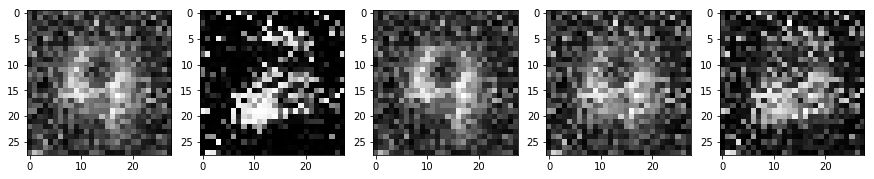

Epoch: 0 Iter: 0/938, G-error: 6.822021007537842 D-error: 0.05180693417787552


KeyboardInterrupt: 

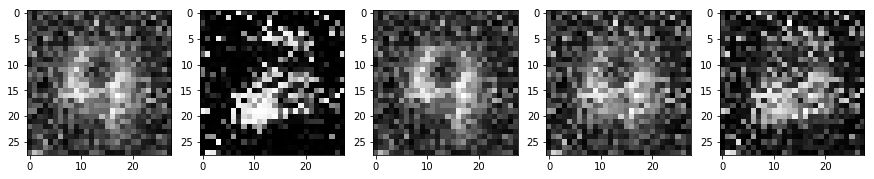

In [19]:
num_test_samples = 5
test_noise = torch.randn(num_test_samples, 100)

num_epochs = 10

for epoch in range(num_epochs):
    for i, (real_batch, _) in enumerate(train_loader):
        batch_size = real_batch.shape[0]
        # generate fake data and train discriminator
        fake_data = generator(torch.randn(batch_size, 100))
        # train the network
        d_error = train_discriminator(d_optimizer, real_batch, fake_data)

        # generate fake data and train discriminator
        fake_data = torch.randn(batch_size, 100)
        # train the network
        g_error = train_generator(g_optimizer, fake_data)

        if i % 200 == 0:
            test_images = generator(test_noise).view(-1, 28, 28).data.cpu()
            plot(test_images)
             
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)}, G-error: {g_error.item()} D-error: {d_error.item()}")
